cuda:0


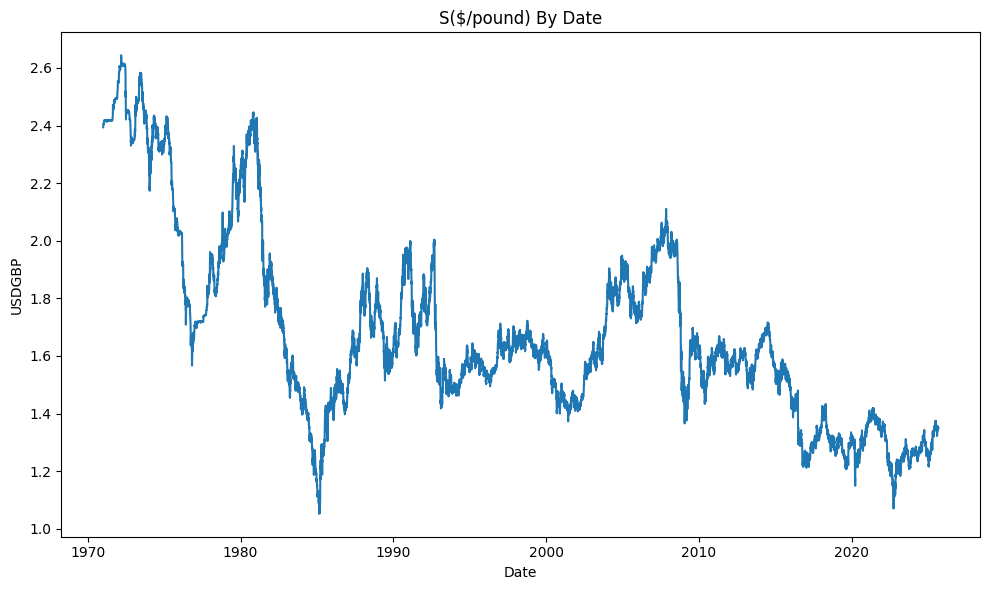

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv("FRED_API_KEY")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_percentage_error


device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)



usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

df = pd.concat([usdgbp],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDGBP',data=df)
plt.title("S($/pound) By Date")
plt.savefig("images/spotrate.png")
plt.tight_layout()
plt.show()






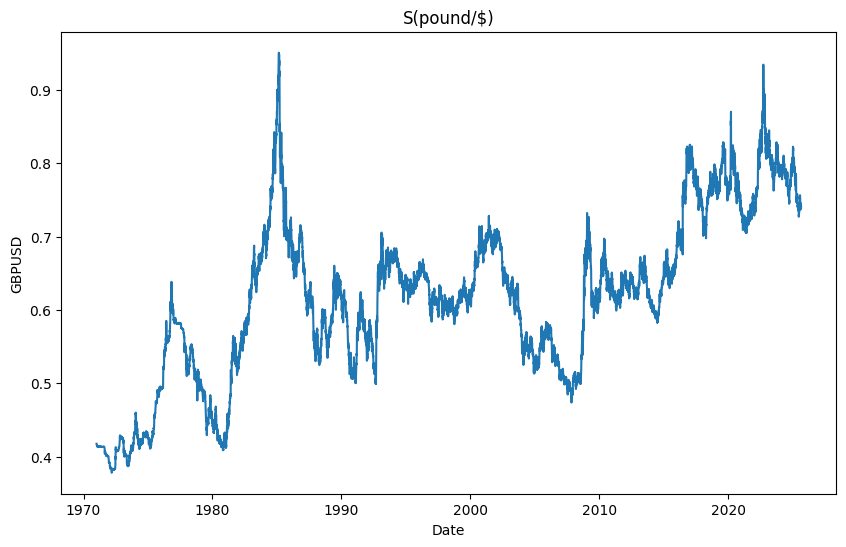

In [2]:



df['GBPUSD'] = 1 / df['USDGBP']

plt.figure(figsize=(10,6))
sns.lineplot(x=df['Date'],y=df['GBPUSD'])
plt.title("S(pound/$)")
plt.savefig("images/sportrate_GBPUSD")
plt.show()




In [3]:

#there is no Arbitrage for trading currency pairs in the FX market
#1 / USDGBP == GBPUSD; 1 / GBPUSD == USDGBP"""



A = np.array([[df['USDGBP'][1],df['GBPUSD'][1]],[df['GBPUSD'][1],df['USDGBP'][1]]])

print(f'1:1 Parity of of Exchange Rates: {A.T}')



1:1 Parity of of Exchange Rates: [[2.3949     0.41755397]
 [0.41755397 2.3949    ]]


In [4]:
df.drop("GBPUSD",inplace=True,axis=1)
df.drop_duplicates(inplace=True)

df_train = df.iloc[:,0:1].values



train_size = int(len(df_train) * .90)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 1

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()




class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(1,X.size(0),self.hidden_size)
        c0 = torch.zeros(1,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out





In [5]:
model = LSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
epochs = 500


for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

/tmp/ipykernel_50475/1082929674.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_50475/1082929674.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.4306; Test RSME: 0.1163
Epoch: 1; train_RSEM: 0.4195; Test RSME: 0.1058
Epoch: 2; train_RSEM: 0.4085; Test RSME: 0.0956
Epoch: 3; train_RSEM: 0.3975; Test RSME: 0.08557
Epoch: 4; train_RSEM: 0.3865; Test RSME: 0.0758
Epoch: 5; train_RSEM: 0.3755; Test RSME: 0.06642
Epoch: 6; train_RSEM: 0.3645; Test RSME: 0.05762
Epoch: 7; train_RSEM: 0.3534; Test RSME: 0.04977
Epoch: 8; train_RSEM: 0.3423; Test RSME: 0.04349
Epoch: 9; train_RSEM: 0.3311; Test RSME: 0.03967
Epoch: 10; train_RSEM: 0.3198; Test RSME: 0.03922
Epoch: 11; train_RSEM: 0.3084; Test RSME: 0.04243
Epoch: 12; train_RSEM: 0.297; Test RSME: 0.04876
Epoch: 13; train_RSEM: 0.2855; Test RSME: 0.05737
Epoch: 14; train_RSEM: 0.274; Test RSME: 0.06754
Epoch: 15; train_RSEM: 0.2626; Test RSME: 0.0788
Epoch: 16; train_RSEM: 0.2512; Test RSME: 0.09086
Epoch: 17; train_RSEM: 0.2401; Test RSME: 0.1035
Epoch: 18; train_RSEM: 0.2293; Test RSME: 0.1167
Epoch: 19; train_RSEM: 0.2189; Test RSME: 0.1302
Epoch: 20; train_RSE

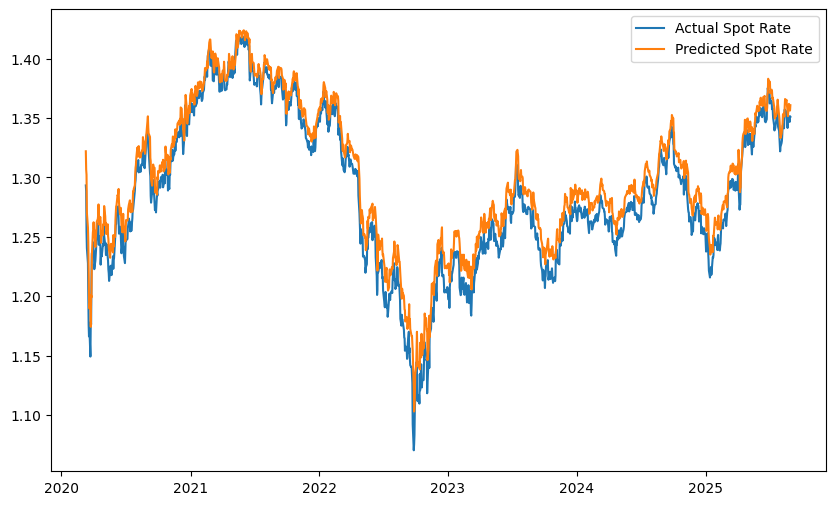

In [6]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length:]['Date']


comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate-USD-GBP.png")
plt.show()


In [7]:
r2 = r2_score(y_test_np,pred_np)
print(f'R2 Score: {r2*100:.2f}%')
rmse = root_mean_squared_error(y_test_np,pred_np)
print(f"Root Mean Squared Error: {rmse:.4f}")

mape = mean_absolute_percentage_error(y_test_np,pred_np)
print(f'Mean Average Percentage Error: {mape:.4f}')


print(np.round(comparison_df,4).head(20))
print(np.round(comparison_df,4).tail(20))


R2 Score: 93.65%
Root Mean Squared Error: 0.0103
Mean Average Percentage Error: 0.0786
            Date  Actual Spot Rate  Predicted Spot Rate
12338 2020-03-10            1.2933               1.3221
12339 2020-03-11            1.2887               1.3066
12340 2020-03-12            1.2541               1.3023
12341 2020-03-13            1.2406               1.2703
12342 2020-03-16            1.2278               1.2579
12343 2020-03-17            1.2017               1.2461
12344 2020-03-18            1.1760               1.2221
12345 2020-03-19            1.1662               1.1987
12346 2020-03-20            1.1743               1.1897
12347 2020-03-23            1.1492               1.1971
12348 2020-03-24            1.1784               1.1743
12349 2020-03-25            1.1763               1.2009
12350 2020-03-26            1.2140               1.1989
12351 2020-03-27            1.2360               1.2334
12352 2020-03-30            1.2392               1.2536
12353 2020-03-31 